In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import shutil

2025-08-22 09:53:38.878761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755856419.116664      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755856419.184818      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


**Set seeds for reproducibility**

In [4]:
import random
import numpy as np
import tensorflow as tf


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Constants
DATASET_PATH = "/kaggle/input/bd-rice-dataset/compressed"
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 80
SEED = 42
L2 = 1e-4

# Data generator (no heavy augmentation, already augmented dataset)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Detected {NUM_CLASSES} classes.")

# Compute class weights
classes = train_gen.classes
class_labels = np.unique(classes)
cw = compute_class_weight(class_weight='balanced', classes=class_labels, y=classes)
class_weight = dict(zip(class_labels, cw))
print("Class weights computed.")

# Conv block helper
def conv_block(x, filters, kernel_size=3, pool=True, dropout=0.15):
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if pool:
        x = layers.MaxPooling2D((2,2))(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

# Model architecture
inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_block(inp, 32, dropout=0.1)
x = conv_block(x, 64, dropout=0.15)
x = conv_block(x, 128, dropout=0.2)
x = conv_block(x, 256, dropout=0.25)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(L2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inp, out)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early stopping with min epochs
class EarlyStoppingMinEpochs(EarlyStopping):
    def __init__(self, min_epochs=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

earlystop = EarlyStoppingMinEpochs(min_epochs=5, monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, reduce_lr, earlystop]

# Fit
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks
)

Found 2944 images belonging to 8 classes.
Found 736 images belonging to 8 classes.
Detected 8 classes.
Class weights computed.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,313,832 (5.01 MB)

 Trainable params: 1,310,888 (5.00 MB)

 Non-trainable params: 2,944 (11.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 551ms/step - accuracy: 0.3225 - loss: 2.1406 - val_accuracy: 0.1250 - val_loss: 2.2040 - learning_rate: 1.0000e-04
Epoch 2/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.6863 - loss: 1.2344 - val_accuracy: 0.1250 - val_loss: 2.4647 - learning_rate: 1.0000e-04
Epoch 3/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 404ms/step - accuracy: 0.7622 - loss: 1.0276 - val_accuracy: 0.1902 - val_loss: 2.6049 - learning_rate: 1.0000e-04
Epoch 4/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8423 - loss: 0.8624
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.8423 - loss: 0.8621 - val_accuracy: 0.2989 - val_loss: 2.2698 - learning_rate: 1.0000e-04
Epoch 5/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 405ms/step - accuracy: 0.8924 - loss: 0.7146 - val_accuracy: 0.4375 - val_loss: 1.8606 - learning_rate: 5.0000e-05
Epoch 6/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 408ms/step - accuracy:

**Train the Model**

In [7]:
history = model.fit(
    train_gen,                  # training generator
    validation_data=val_gen,    # validation generator
    epochs=EPOCHS,               # we set EPOCHS = 80 above
    class_weight=class_weight,   # handles class imbalance
    callbacks=callbacks          # checkpoint, LR reduction, early stopping
)

Epoch 1/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.9670 - loss: 0.5300 - val_accuracy: 0.9171 - val_loss: 0.6456 - learning_rate: 6.2500e-06
Epoch 2/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.9639 - loss: 0.5211 - val_accuracy: 0.9280 - val_loss: 0.6243 - learning_rate: 6.2500e-06
Epoch 3/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 366ms/step - accuracy: 0.9609 - loss: 0.5296 - val_accuracy: 0.8981 - val_loss: 0.6881 - learning_rate: 6.2500e-06
Epoch 4/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.9628 - loss: 0.5325 - val_accuracy: 0.9280 - val_loss: 0.6229 - learning_rate: 6.2500e-06
Epoch 5/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.9636 - loss: 0.5274 - val_accuracy: 0.9076 - val_loss: 0.6642 - learning_rate: 6.2500e-06
Epoch 6/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 363ms/step - accuracy: 0.9599 - loss: 0.5286 - val_accuracy: 0.9280 - val_loss: 0.6153 - learning_rate: 6.2500e-06
Epoch 7/80
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - acc

**Plot Accuracy & Loss**

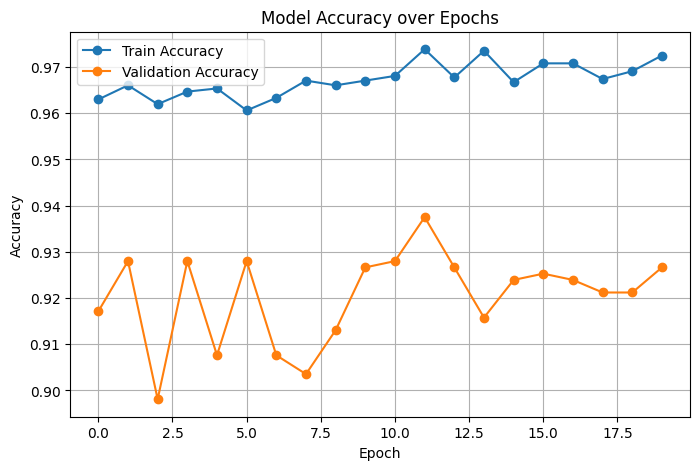

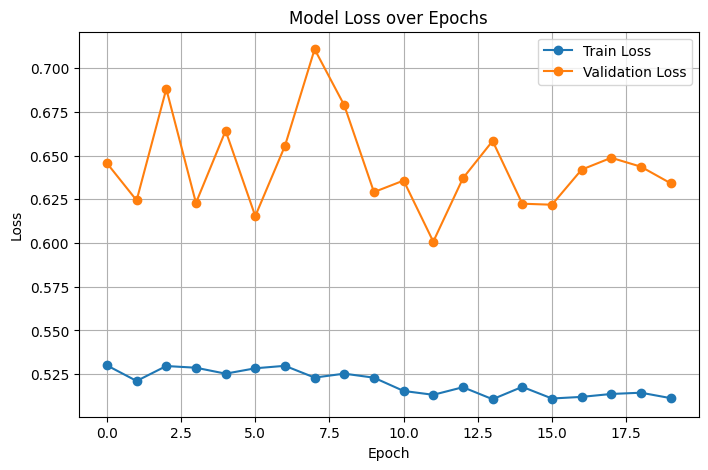

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

**Classification Report & Confusion Matrix**

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step
Classification Report:

                             precision    recall  f1-score   support

          AthasP_compressed       0.99      0.79      0.88        92
           MIjan_Compressed       1.00      0.98      0.99        92
Mojammel miniket_Compressed       0.92      0.99      0.95        92
        Mojumdar_compressed       0.85      0.97      0.90        92
           Nabil_compressed       0.87      1.00      0.93        92
           haski_compressed       1.00      0.90      0.95        92
          paijam_compressed       0.93      1.00      0.96        92
    udsab najir_Compreessed       1.00      0.87      0.93        92

                   accuracy                           0.94       736
                  macro avg       0.94      0.94      0.94       736
               weighted avg       0.94      0.94      0.94       736



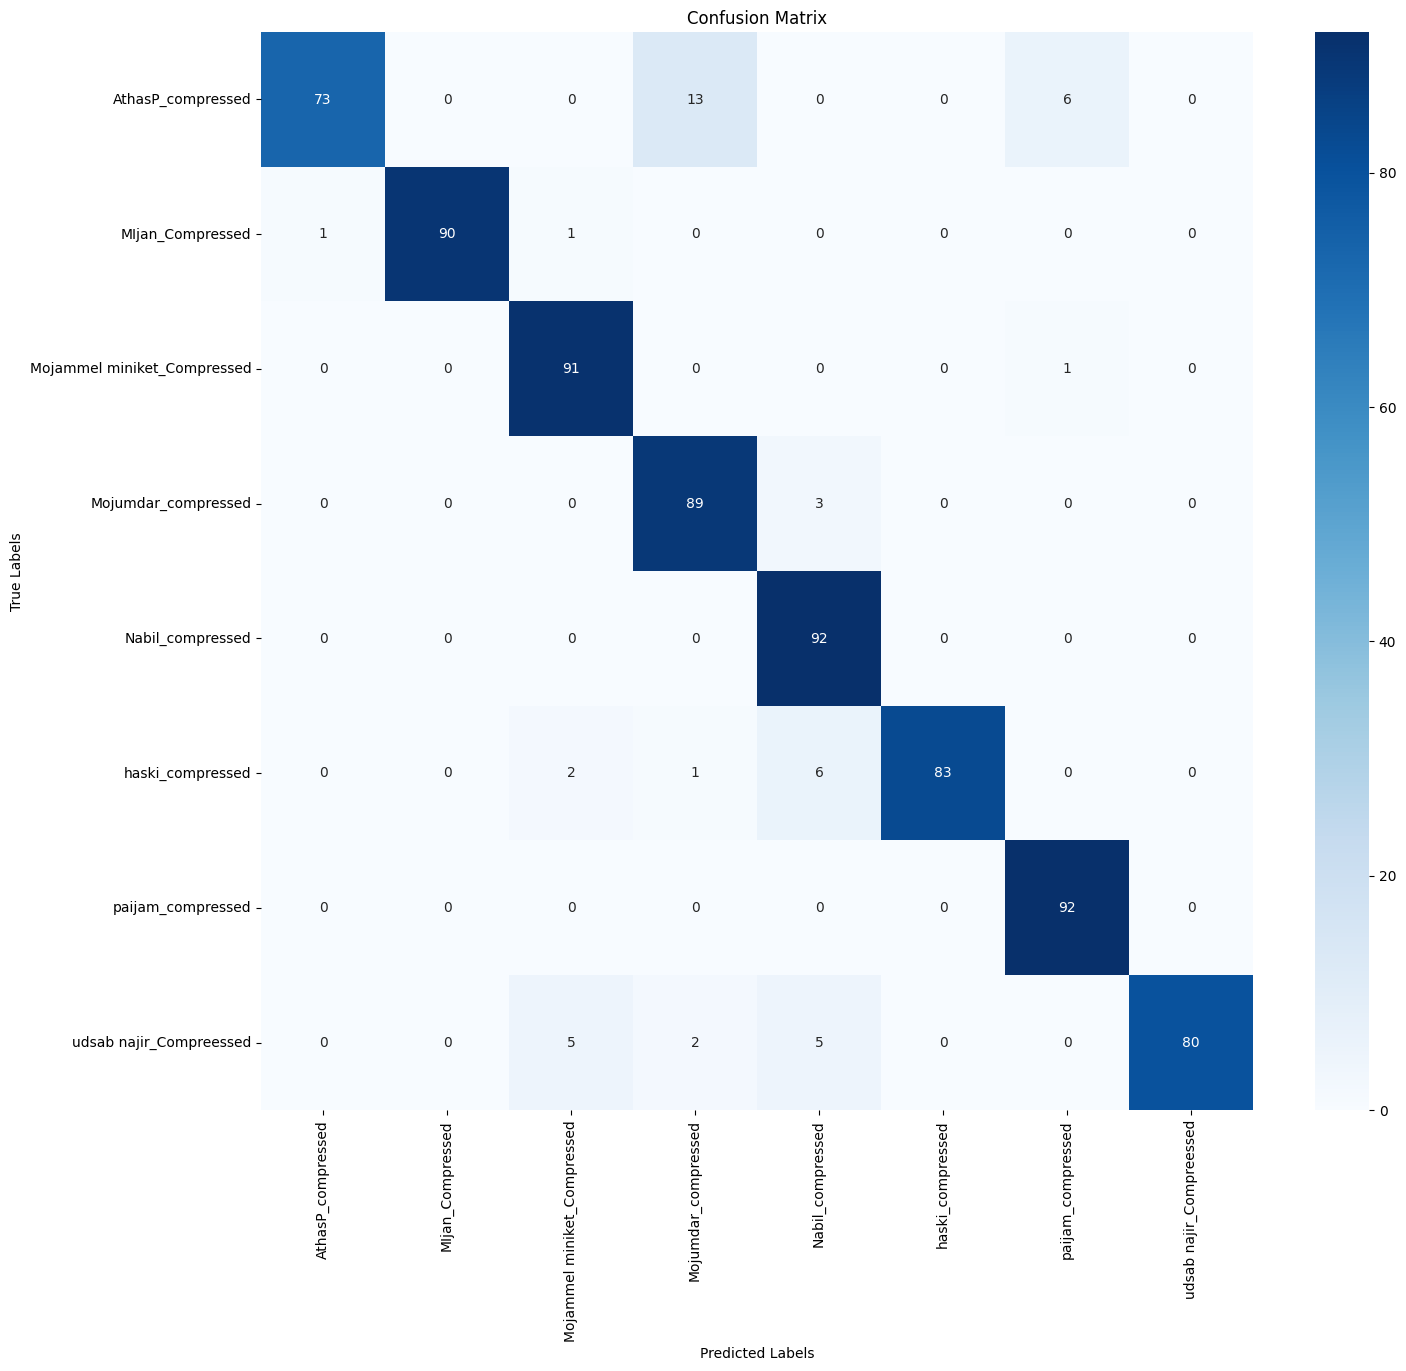

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset validation generator to start from first batch
val_gen.reset()

# Get predictions
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification report (includes precision, recall, f1-score, support)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with values visible
plt.figure(figsize=(16,14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

**ROC-AUC Curves:**

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step


/tmp/ipykernel_36/2929492796.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


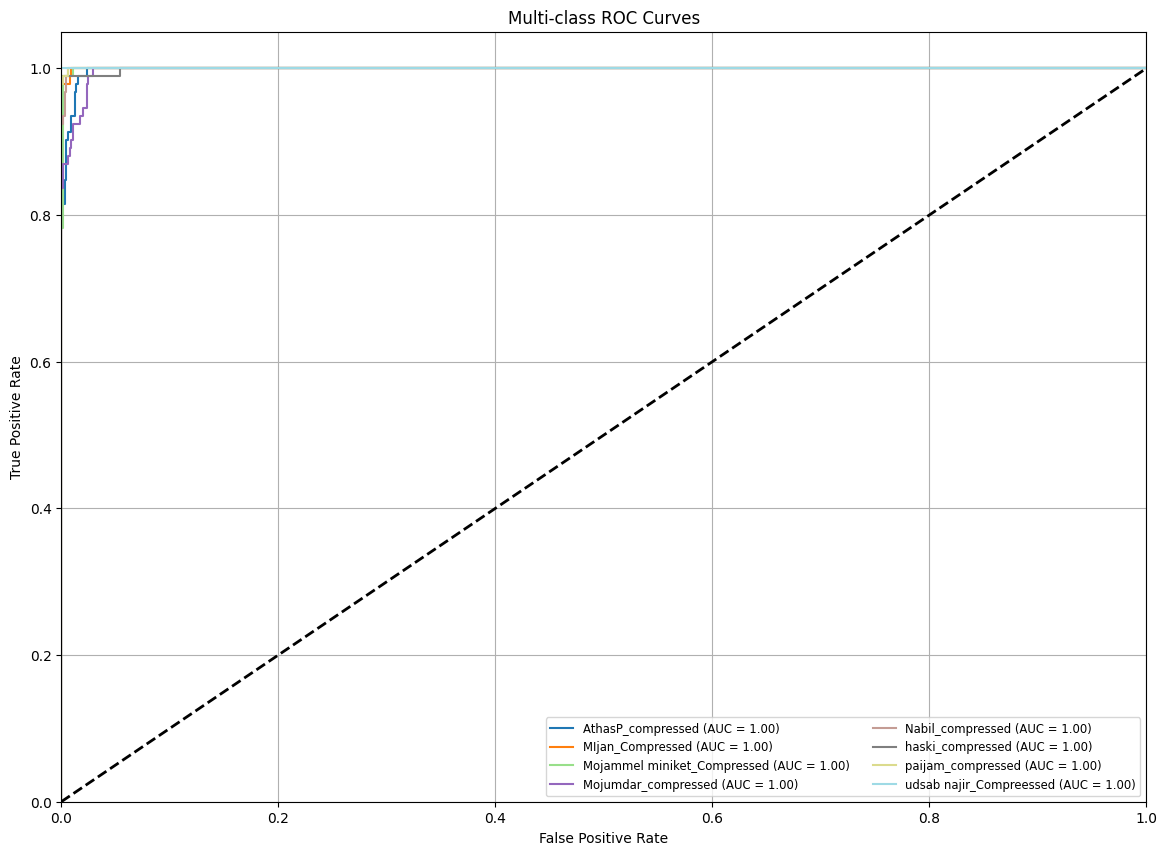

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Reset validation generator
val_gen.reset()

# True labels and predicted probabilities
y_true = val_gen.classes
y_score = model.predict(val_gen, verbose=1)  # shape (num_samples, num_classes)

# Binarize the true labels for multi-class ROC
n_classes = len(val_gen.class_indices)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))

colors = plt.cm.get_cmap('tab20', n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i),
             label=f'{list(val_gen.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.show()

**Learning Curve**

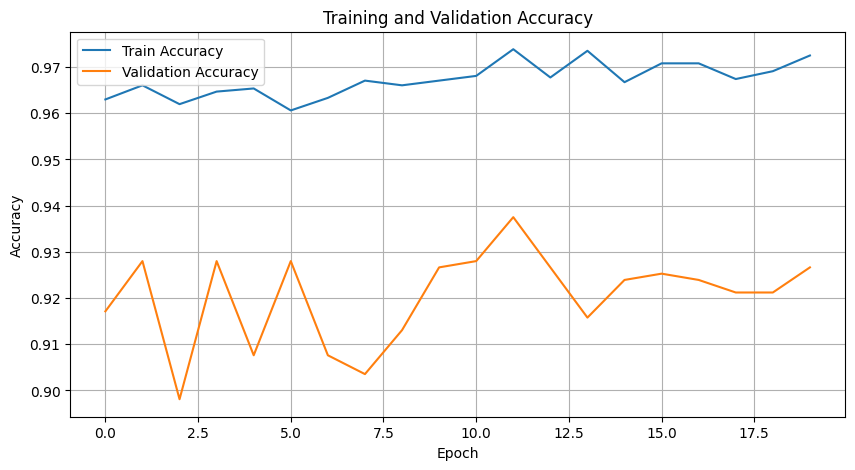

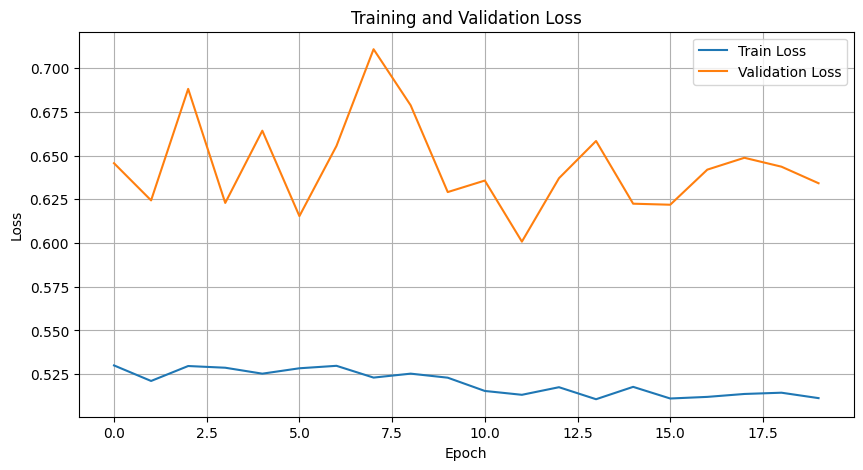

In [11]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Accuracy plot
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training:
plot_learning_curves(history)

**Grad-CAM**

In [12]:
import os

dataset_dir = "/kaggle/input/bd-rice-dataset/compressed"

# Get all class folders inside dataset directory
class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# To store one image path per class
sample_images = []

for class_name in class_folders:
    class_path = os.path.join(dataset_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        # Pick the first image (you can change this to random.choice(images) if you want)
        sample_img = images[0]
        sample_img_path = os.path.join(class_path, sample_img)
        sample_images.append((class_name, sample_img_path))
    else:
        print(f"No images found in class folder: {class_name}")

# Print all selected image paths
for class_name, img_path in sample_images:
    print(f"{class_name}: {img_path}")

Mojammel miniket_Compressed: /kaggle/input/bd-rice-dataset/compressed/Mojammel miniket_Compressed/208.jpg
MIjan_Compressed: /kaggle/input/bd-rice-dataset/compressed/MIjan_Compressed/208.jpg
haski_compressed: /kaggle/input/bd-rice-dataset/compressed/haski_compressed/208.jpg
AthasP_compressed: /kaggle/input/bd-rice-dataset/compressed/AthasP_compressed/208.jpg
Nabil_compressed: /kaggle/input/bd-rice-dataset/compressed/Nabil_compressed/208.jpg
Mojumdar_compressed: /kaggle/input/bd-rice-dataset/compressed/Mojumdar_compressed/208.jpg
udsab najir_Compreessed: /kaggle/input/bd-rice-dataset/compressed/udsab najir_Compreessed/208.jpg
paijam_compressed: /kaggle/input/bd-rice-dataset/compressed/paijam_compressed/208.jpg


Processing: /kaggle/input/bd-rice-dataset/compressed/Mojammel miniket_Compressed/208.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_39']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


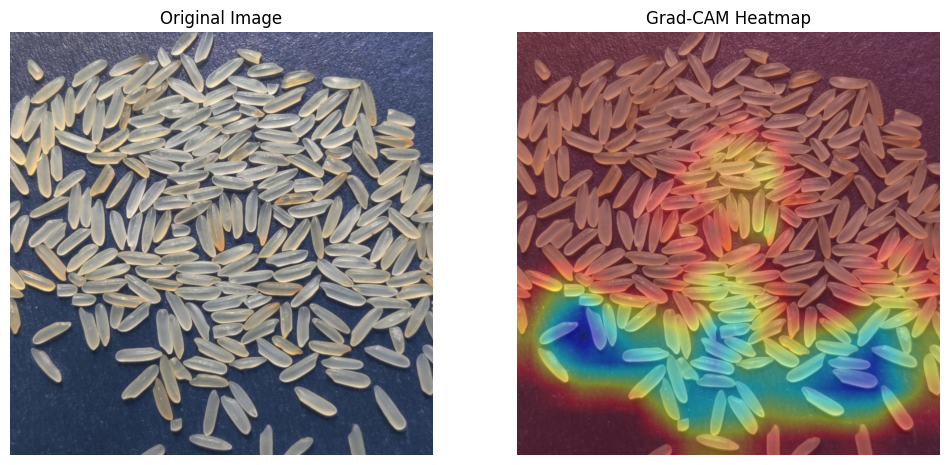

Processing: /kaggle/input/bd-rice-dataset/compressed/MIjan_Compressed/208.jpg


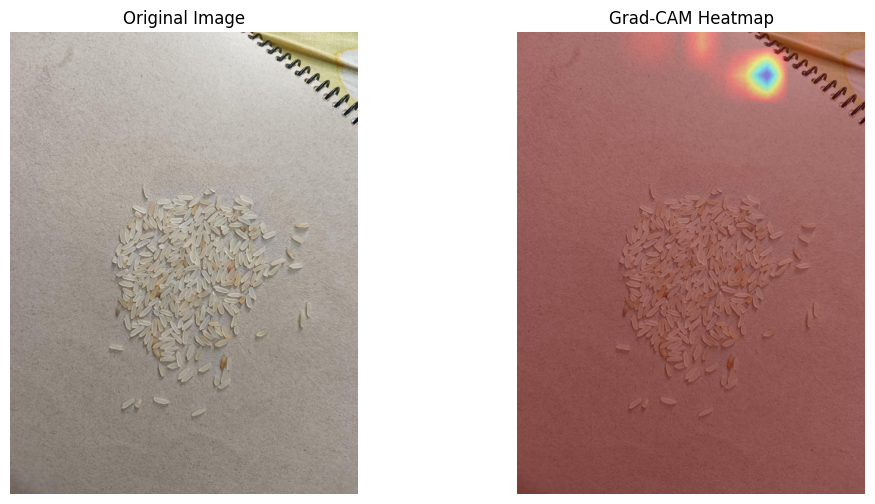

Processing: /kaggle/input/bd-rice-dataset/compressed/haski_compressed/208.jpg


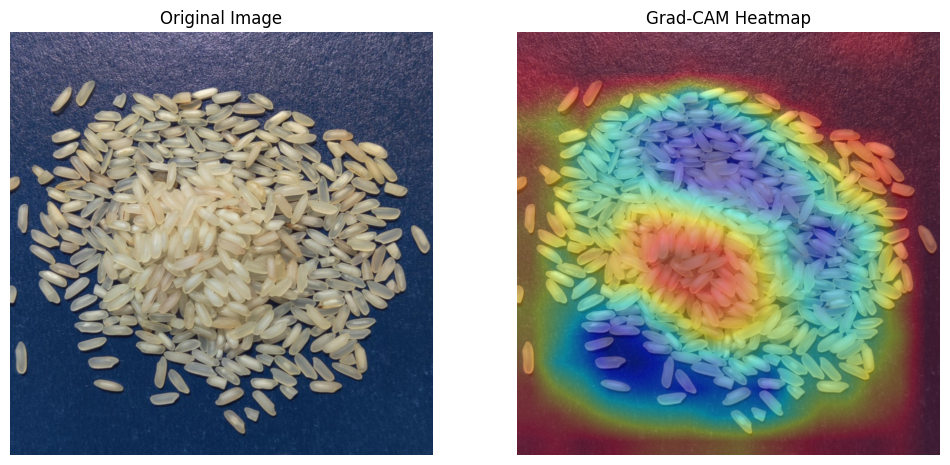

Processing: /kaggle/input/bd-rice-dataset/compressed/AthasP_compressed/208.jpg


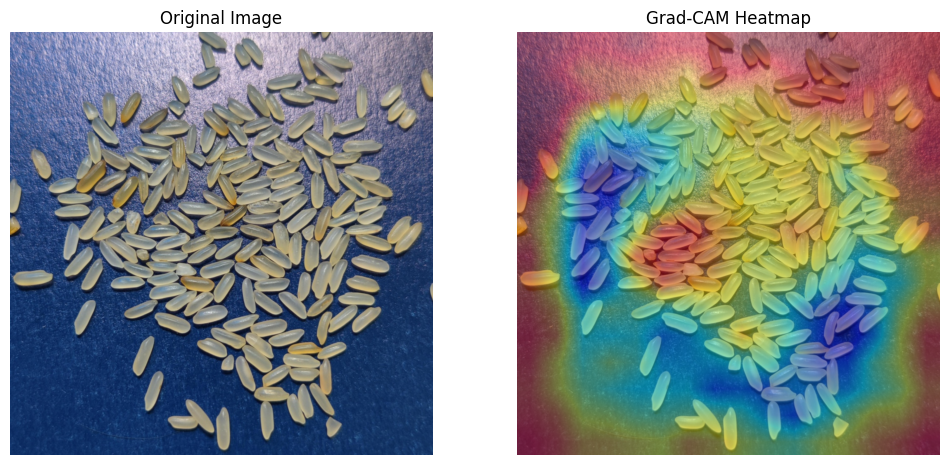

Processing: /kaggle/input/bd-rice-dataset/compressed/Nabil_compressed/208.jpg


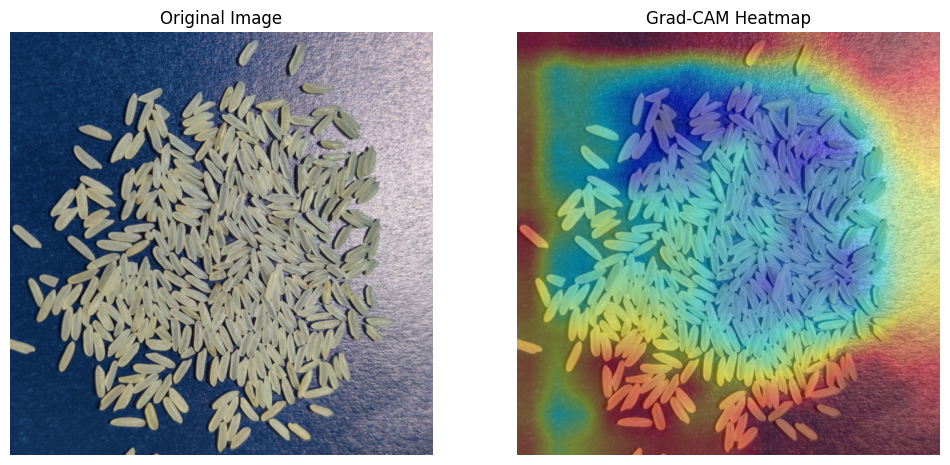

Processing: /kaggle/input/bd-rice-dataset/compressed/Mojumdar_compressed/208.jpg


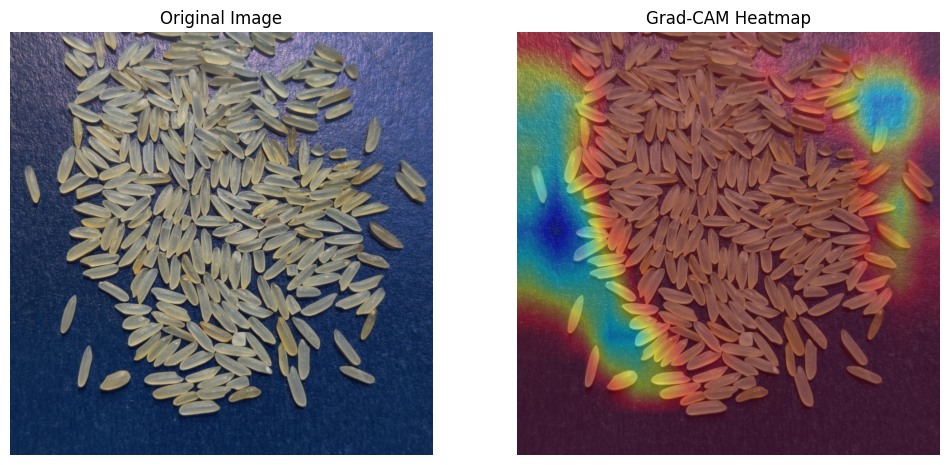

Processing: /kaggle/input/bd-rice-dataset/compressed/udsab najir_Compreessed/208.jpg


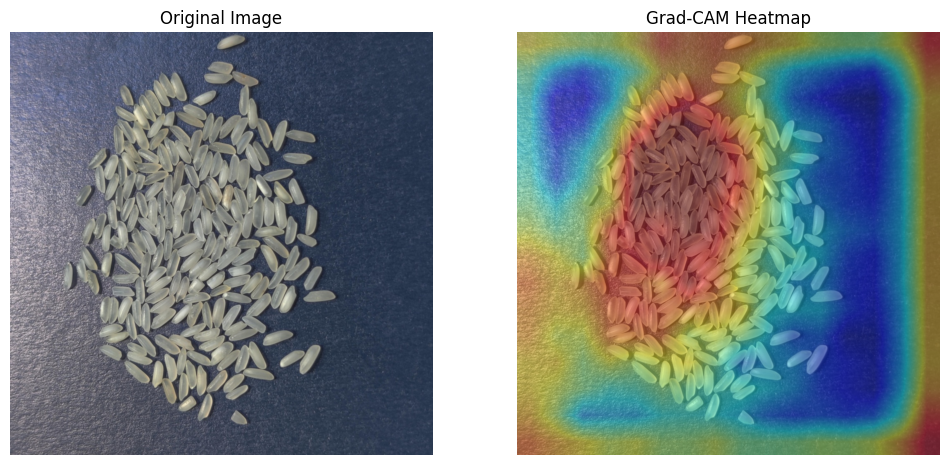

Processing: /kaggle/input/bd-rice-dataset/compressed/paijam_compressed/208.jpg


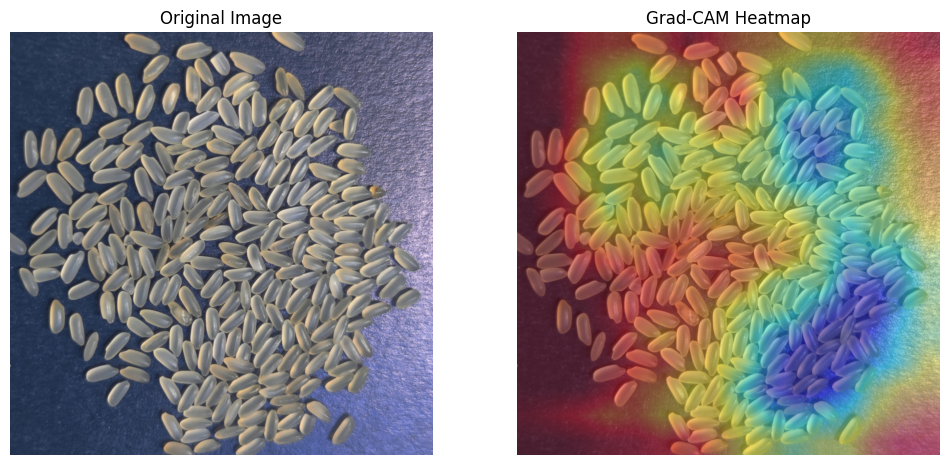

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    """Load and preprocess image."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0  # normalize as during training
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_side_by_side(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

# ==== USAGE ====

last_conv_layer_name = "conv2d_15"  # Replace with your actual last conv layer name

# List of 32 image paths
image_paths = [
   "/kaggle/input/bd-rice-dataset/compressed/Mojammel miniket_Compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/MIjan_Compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/haski_compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/AthasP_compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/Nabil_compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/Mojumdar_compressed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/udsab najir_Compreessed/208.jpg",
"/kaggle/input/bd-rice-dataset/compressed/paijam_compressed/208.jpg",
]


for img_path in image_paths:
    print(f"Processing: {img_path}")
    img_array = get_img_array(img_path, size=(128, 128))  # use your IMG_SIZE
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam_side_by_side(img_path, heatmap, alpha=0.4)